In [1]:
import time
import os.path
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Load dataset

In [2]:
%%time
df1 = pd.read_csv("./small_2015-06_key_word.csv",index_col=False, header=None, names=['id','text','food','activity','label'])
df2 = pd.read_csv("./small_2015-11_key_word.csv",index_col=False, header=None, names=['id','text','food','activity','label'])
df = pd.concat((df1,df2),axis=0)
lst = []
for i,sentence in enumerate(df['text']):
    try:
        if len(sentence.split(' ')) > 4:
            lst.append(i)
    except:
        continue
# activity
# df = df.iloc[lst].replace(3,2).reset_index(drop=True)
# food
df = df.iloc[lst].replace(3,1).reset_index(drop=True)

CPU times: user 32.5 s, sys: 2.79 s, total: 35.3 s
Wall time: 30.8 s


In [3]:
pkl.dump(df,open('df.pickle','wb'))

In [4]:
print(df.shape)
df.head()

(7316139, 5)


,id,text,food,activity,label
0,611162865551192064,for ailment sun remedy none if try find,NaN,NaN,0
1,611165766952591360,remind blessed i walk office today,NaN,walk,2
2,611159320655347712,unarmed white teen shot black officer,NaN,NaN,0
3,611133193811423233,supplemental health care rn register nurse er id,NaN,NaN,0
4,611055426663112705,dad make porn be little frisky,NaN,NaN,0


## Default random forest

Feed different LDA model's output into a __default__ random forest

In [2]:
def feed_lda(num_topics,max_features,max_df,df):
    # load tf_vectorizer and lda model
    tf_path = 'data/tfVectorizer_topics={}_maxFeatures={}_maxDf={}_minDf=1.pickle'.format(num_topics,max_features,max_df)
    lda_path = 'data/LDA_topics={}_maxFeatures={}_maxDf={}_minDf=1.pickle'.format(num_topics,max_features,max_df)
    name = "topics={}_maxFeatures={}_maxDf={}".format(num_topics,max_features,max_df)
    if (os.path.exists(tf_path)) & ( os.path.exists(lda_path)):
        with open(tf_path,'rb') as input_file:
            tf_vectorizer = pkl.load(input_file)
        with open(lda_path, "rb") as input_file:
            lda = pkl.load(input_file)
            
    # predicts probs of text using lda
    start = time.time()
    probs = lda.transform(tf_vectorizer.transform(df['text'].tolist()))
    X = pd.concat((df,pd.DataFrame(probs)),axis=1)

    # randomly sample a balanced dataset
#     activity
#     X0 = X[X['label']==0].sample(X.groupby('label').size()[2])
#     X = pd.concat((X0,X[X['label']==2]),axis=0)
#     food
    X0 = X[X['label']==0].sample(X.groupby('label').size()[1])
    X = pd.concat((X0,X[X['label']==1]),axis=0)
    
    X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,5:],X['label'],test_size=0.2,random_state=42)
    return name, X_train, X_test, y_train, y_test

def do_train(model, X_train, X_test, y_train, y_test):
    # train random forest
    print('training...')
    model.fit(X_train,y_train)
    print('testing...')
    acc = round(model.score(X_test,y_test),4)
    return acc

In [25]:
from sklearn.model_selection import ParameterGrid
grid1 = {'num_topics':[25,50,75,100],
        'max_features':[12000,16000],
        'max_df':[0.4,0.5,0.6]}
grid2 = {'num_topics':[100],
         'max_features':[20000,25000],
         'max_df':[0.5,0.75]}
grid3 = {'num_topics':[125],
         'max_features':[20000,25000],
         'max_df':[0.5]}
comb = list(ParameterGrid(grid1)) + list(ParameterGrid(grid2)) + list(ParameterGrid(grid3))

In [32]:
lda_lst, acc_lst = [], []
for param in comb:
    name, X_train, X_test, y_train, y_test = feed_lda(param['num_topics'], param['max_features'], param['max_df'], df)
    model = RandomForestClassifier(n_estimators=10,random_state=0)
    acc = do_train(model, X_train, X_test, y_train, y_test)
    print(name, acc)
    lda_lst.append(name)
    acc_lst.append(acc)

/Users/ice/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [94]:
default = pd.DataFrame()
default['lda model'] = lda_lst
default['acc'] = acc_lst
default

## Hyperparameter tuning for random forest

### Load our best lda model: num_topics=125, maxFeatures=25000, maxDf=0.5

In [6]:
%%time
_, X_train, X_test, y_train, y_test = feed_lda(125, 25000, 0.5, df)

In [98]:
# sum(y_train==2), sum(y_train==0)
sum(y_train==1), sum(y_train==0)

(312095, 312279)

### ablation study

In [6]:
def tune_param(param, param_lst):
    lst = []
    for val in param_lst:
        locals()[param] = val
        print(param+' =',val)
        start = time.time()
        model = RandomForestClassifier(n_jobs=-1,max_features=max_features,max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,n_estimators=n_estimators)
        acc = do_train(model, X_train, X_test, y_train, y_test)
        lst.append(acc)
        end = time.time()
        print('acc:',acc)
        print('running time:', round(end-start,4),'s')
    
    df = pd.DataFrame()
    df[param] = param_lst
    df['acc'] = lst
    df = df.sort_values(by=['acc'],ascending=False).reset_index(drop=True)
    return df

In [116]:
# set a default value
bootstrap = False
max_depth = 10
max_features = 50
min_samples_leaf= 2
min_samples_split = 5
n_estimators = 10

In [107]:
# alternative values
grid = {'bootstrap': [True, False],
         'max_depth': [10, 30, 50, 70, 90, None],
         'max_features': ['sqrt', 10, 25, 50, 100],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10, 20],
         'n_estimators': [200, 400, 600, 10]}

- n_estimator

In [114]:
df_n_estimator = tune_param('n_estimator',grid['n_estimator'])
df_n_estimator

,n_estimator,acc
0,100,0.7612
1,10,0.7571
2,200,0.7542
3,600,0.7516
4,400,0.7512


- bootstrap

In [118]:
df_bootstrap = tune_param('bootstrap',grid['bootstrap'])
df_bootstrap

,bootstrap,acc
0,True,0.7634
1,False,0.7612


- max_depth

In [120]:
df_max_depth = tune_param('max_depth',grid['max_depth'])
df_max_depth

,max_depth,acc
0,90.0,0.7620
1,50.0,0.7613
2,NaN,0.7611
3,30.0,0.7600
4,70.0,0.7595
5,10.0,0.7580


- max_features

In [135]:
df_max_features = tune_param('max_features',grid['max_features'])
df_max_features

,max_features,acc
0,100,0.7616
1,150,0.7609
2,25,0.7601
3,50,0.7589


- min_samples_leaf

In [131]:
df_min_samples_leaf = tune_param('min_samples_leaf',grid['min_samples_leaf'])
df_min_samples_leaf

,min_samples_leaf,acc
0,2,0.7625
1,4,0.7591
2,1,0.7561


- min_samples_split

In [130]:
df_min_samples_split = tune_param('min_samples_split',grid['min_samples_split'])
df_min_samples_split

,min_samples_split,acc
0,10.0,0.7646
1,5.0,0.7641
2,2.0,0.7598
3,20.0,0.7595


### best model

In [7]:
%%time
best_model = RandomForestClassifier(n_jobs=-1,max_features=100,max_depth=90,min_samples_leaf=2,min_samples_split=10,n_estimators=100)
best_acc = do_train(best_model, X_train, X_test, y_train, y_test)
print('Best model:', best_model)
print('Best accuracy:', best_acc)

Best model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features=100, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Best accuracy: 0.7643
CPU times: user 5h 35min 39s, sys: 53.3 s, total: 5h 36min 32s
Wall time: 46min 25s


In [32]:
pkl.dump(best_model, open('best_model_food.pickle','wb'))
pkl.dump([X_train, X_test, y_train, y_test], open('data_food.pickle','wb'))

- feature importance (sum=1)

In [16]:
fi = pd.DataFrame()
fi['importance'] = best_model.feature_importances_
print(fi.sort_values(by=['importance'],ascending=False)[:10])
top4 = list(fi.sort_values(by=['importance'],ascending=False).iloc[:4].index)

     importance
83     0.089490
75     0.044159
124    0.033437
57     0.027692
41     0.022732
93     0.021227
51     0.020551
81     0.018480
52     0.018346
53     0.012780


In [17]:
top4

[83, 75, 124, 57]

In [18]:
def print_topics(model, feature_names, top_k, top_topics):
    """
    Print the most important words of each topics
    """
    for ind, topic in enumerate(model.components_):
        if ind in top_topics:
            print("Topic #" + str(ind), 'importance =', round(fi['importance'][ind],4))
            # print out top k possible features(words)
            print([feature_names[i] for i in topic.argsort()[:-top_k-1:-1]])
    return

with open('data/tfVectorizer_topics=125_maxFeatures=25000_maxDf=0.5_minDf=1.pickle','rb') as input_file:
    tf = pkl.load(input_file)
with open('data/LDA_topics=125_maxFeatures=25000_maxDf=0.5_minDf=1.pickle', "rb") as input_file:
    lda = pkl.load(input_file)

feature_names = tf.get_feature_names()
print_topics(lda, feature_names, 30, top4)

Topic #57 importance = 0.0277
['today', 'great', 'win', 'restaurant', 'celebrate', 'market', 'trail', 'group', 'bank', 'treat', 'decide', 'age', 'blog', 'oyster', 'ann', '1130', 'farmers', 'passion', 'peter', 'balance', 'turtle', 'trainer', 'stack', 'confirm', 'marsh', 'russia', 'startup', 'pelican', 'bennett', '323']
Topic #75 importance = 0.0442
['run', 'team', 'pizza', 'these', 'chocolate', 'usa', 'attack', 'extra', 'earth', 'salad', 'ground', 'partner', 'david', 'venice', 'pleasure', 'creative', 'edge', 'frank', 'review', 'cancer', 'guard', 'exchange', 'involve', 'powerful', 'resident', 'fund', 'drake', 'sac', 'mag', 'beacon']
Topic #83 importance = 0.0895
['tree', 'chicken', 'near', 'orange', 'campus', 'mexican', 'sauce', 'potato', 'bacon', 'trump', 'beef', 'palace', 'wash', 'pleasant', 'arrest', 'adams', 'fresno', 'manager', 'unit', 'waffle', 'spicy', 'which', 'boulder', 'garlic', 'joseph', 'climb', 'grilled', 'respond', 'samuel', '1115']
Topic #124 importance = 0.0334
['first', 

The topic contributes most to our random forest do have some words like  
'eat','pizza','chicken','bacon','beef','hungry','taste' and etc.

- Load food and activity list

In [19]:
from matplotlib import pyplot as plt

food = list(pkl.load(open("food.pickle","rb")))
food = [i.strip() for i in food]
activity = list(pkl.load(open("activity.pickle","rb")))
activity = [i.strip() for i in activity]

- Plot topics' importance and its food/activity frequency

In [20]:
food_freq_list = []
activity_freq_list = []
combine_freq_list = []

for i in range(len(lda.components_)):
    prob = lda.components_[i] / lda.components_.sum(axis=1)[:, np.newaxis][i]
    # get all the words whose prob > 0.0001 in a specific topic
    top_words_idx = np.where(prob > 0.0001)[0]
    top_words = [tf.get_feature_names()[j] for j in top_words_idx]
    # get frequency of its top words fall into food
    food_freq = sum([word in food for word in top_words])/len(top_words)
    food_freq_list.append(food_freq)
    # get frequency of its top words fall into activity
    activity_freq = sum([word in activity for word in top_words])/len(top_words)
    activity_freq_list.append(activity_freq)
    combine_freq = food_freq + activity_freq
    combine_freq_list.append(combine_freq)

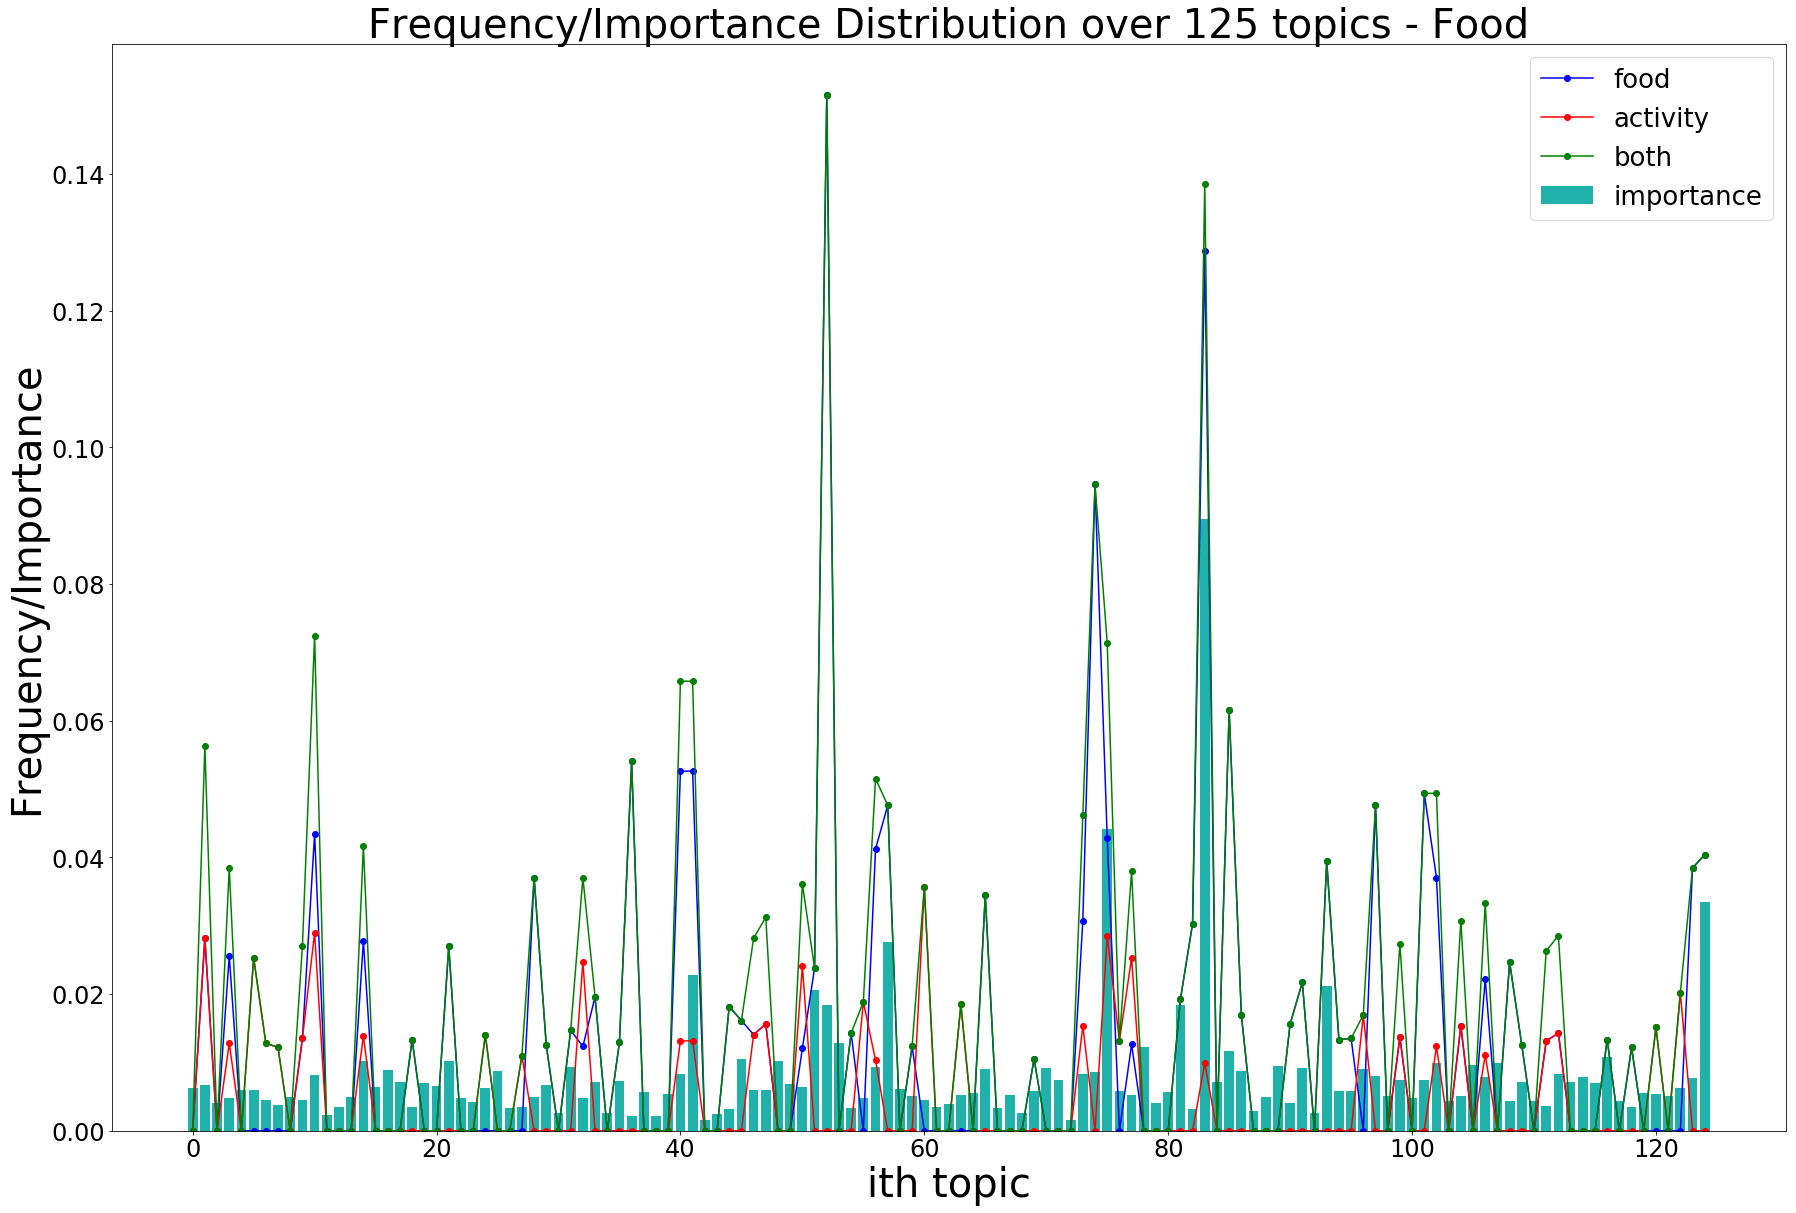

In [28]:
plt.close()
fig = plt.figure(figsize=(30,20))
plt.plot(food_freq_list, label = 'food',color='blue', marker='o')
plt.plot(activity_freq_list,label='activity',color='red',marker = 'o')
plt.plot(combine_freq_list,label = 'both',color='green',marker = 'o' )
plt.bar(range(125),height=fi['importance'],color='lightseagreen',label='importance')
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)

plt.title("Frequency/Importance Distribution over 125 topics - Food",fontsize=40)
plt.xlabel("ith topic",fontsize=40)
plt.ylabel('Frequency/Importance',fontsize=40)
plt.legend(prop={'size': 26})

plt.savefig('feature_importance_food.png') 
plt.show()
# food plot

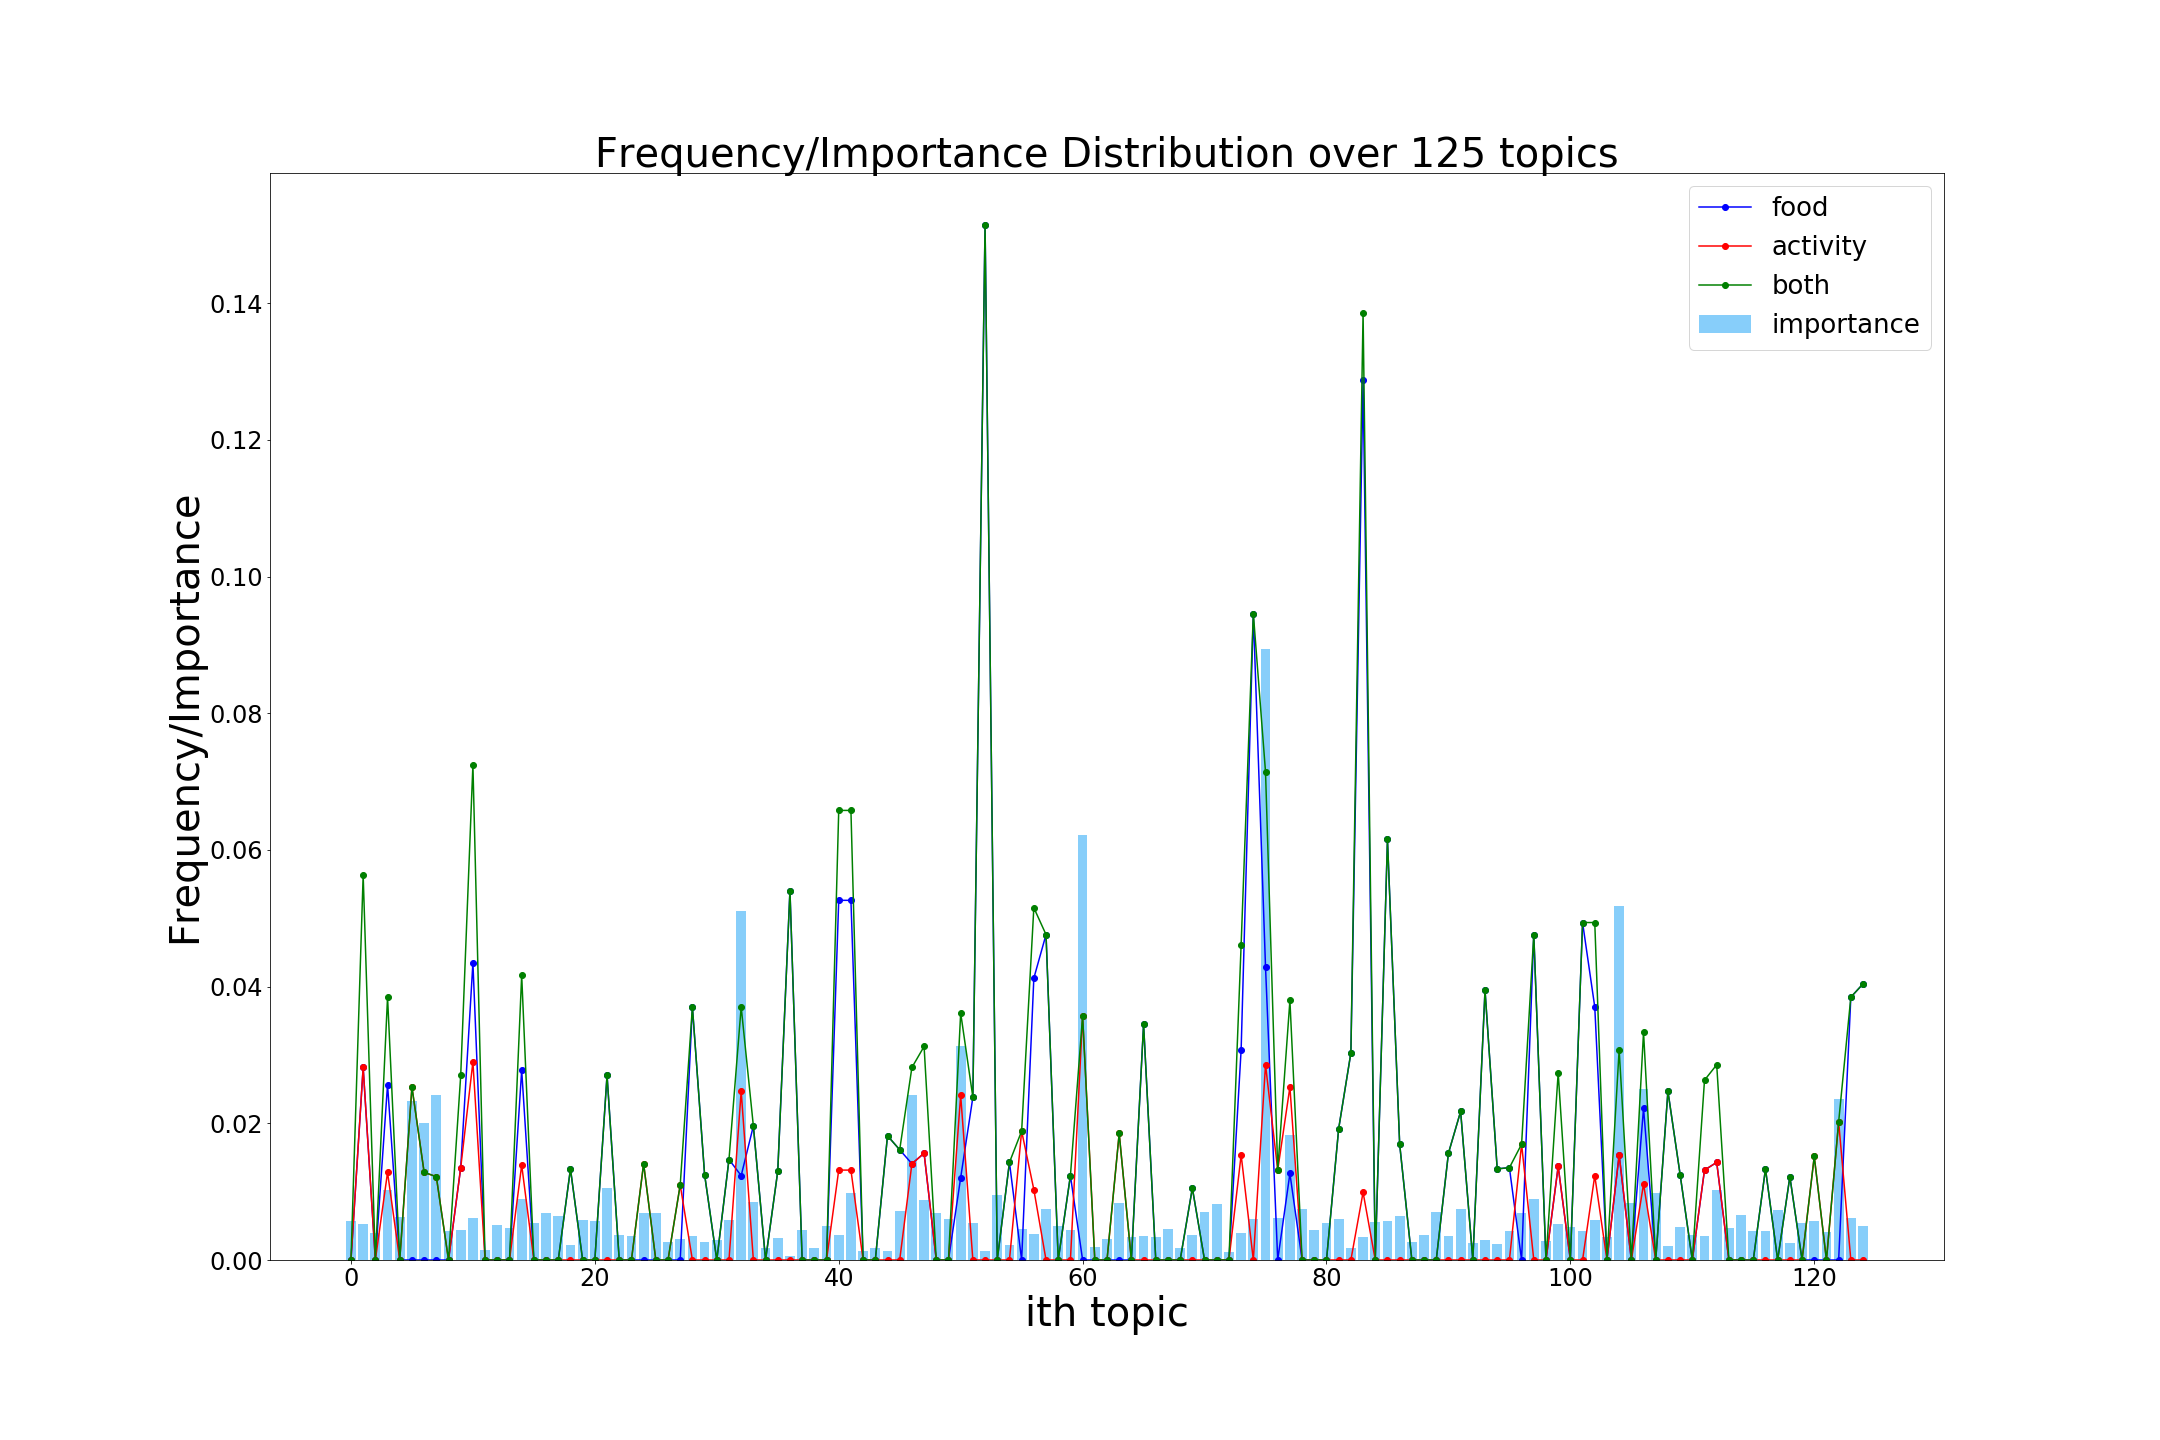

In [31]:
# activity plot
from IPython.display import Image
Image(filename='feature_importance_activity.png')

### RandomizedSearchCV

In [3]:
%%time
with open('data_food.pickle','rb') as input_file:
    X_train, X_test, y_train, y_test = pkl.load(input_file)

CPU times: user 318 ms, sys: 743 ms, total: 1.06 s
Wall time: 1.06 s


In [4]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Create the random grid
grid = {'n_estimators':  list(range(50,160,10)), # Number of trees in a random forest
       'max_features': [0.5,0.6,0.7,0.8,0.9,1.0], # Number of features to consider at every split
       'max_depth': list(range(50,105,5)) + [None], # Maximum number of levels in tree
       'min_samples_split': list(range(5,15)), # Minimum number of samples required to split a node
       }
pprint(grid)

{'max_depth': [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, None],
 'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'min_samples_split': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]}


In [32]:
print('We have', 12*6*10*11, 'combinations all together.')

We have 7920 combinations all together.


In [23]:
num_iter = 20
rf = RandomForestClassifier(bootstrap=True,min_samples_leaf= 2)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = num_iter, cv=3, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

In [35]:
print(list(rf_random.cv_results_['params'][0].keys()))
name_lst = [rf_random.cv_results_['params'][i].values() for i in range(num_iter)]
test_lst = rf_random.cv_results_['mean_test_score']

result = pd.DataFrame()
result['rf model'] = name_lst
result['acc'] = test_lst
result

,model,acc
1,"(80, 0.7, 50, 13)",0.8086
2,"(50, 0.8, 95, 12)",0.8070
6,"(150, 1.0, 50, 9)",0.8069
8,"(70, 0.7, None, 11)",0.8066
5,"(60, 0.5, 90, 10)",0.8062
11,"(150, 0.8, 75, 7)",0.8058
9,"(60, 0.6, 90, 7)",0.8052
0,"(100, 0.5, 85, 12)",0.8049
3,"(120, 0.6, 95, 8)",0.8049
17,"(150, 0.8, 55, 11)",0.8048
